## Summary

I tested the prediction of user-adoption using a random forest classifier against the accuracy using a Naïve Bayes model that predicted user adoption in 100% of cases. The machine learning model only showed a very slight improvement with an accuracy of 0.747 on the test set versus a Naïve Bayes accuracy of 0.733. No variables appear to be strongly predictive, but being invited to join a personal workspace was slightly negatively correlated with becoming an adopted user.

I processed the data to create a list of “adopted users” by looping through the usage summary table ("takehome_user_engagement") for each unique user it contained using the Pandas “rolling” method and finding the maximum number of visits that occurred for them in a 7-day window. Three or greater visits received a “1” in a new “adopted_status” column. This was then merged with the rest of the user data.

A significant training variable that I dropped from the from the takehome_users.csv file was last_session_creation_time, which is the timestamp of the user’s last login. An active user would have a higher frequency of logins and be more likely to have a recent last_session time, but the outcome variable is defined solely by the frequency of logins in a 7-day window. So, this would be a form of the outcome partially leaking into the training data.

A better approach may be to use network analysis to see if there are clusters of connected people via the “invited_by_user_id” variable who have become adopted or not-adopted.


In [1]:
import numpy as np
import pandas as pd

import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt

## Data Cleaning

In [2]:
users = pd.read_csv('takehome_users.csv')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
visits = pd.read_csv('takehome_user_engagement.csv')
visits.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [39]:
print(len(visits))
print(len(visits['time_stamp'].unique()))

207917
207220


There are some identical timestamps so they need to be made unique to work as an index. Add very small random number to datetime and then sort. Index needs to be datetime for pandas rolling function.

In [6]:
# Convert to datetime
visits['time_stamp'] = pd.to_datetime(visits['time_stamp'])

# Make datetimes unique
visits['timedelta'] = np.random.uniform(0,.01)
visits['timedelta'] = pd.to_timedelta(visits['timedelta'])
visits['adj_time'] = visits['time_stamp'] + visits['timedelta']

In [7]:
# Sort in ascending time
visits.sort_values('adj_time', ascending=True, inplace=True)

In [8]:
# Reset the index using the unique timestamps
visits.set_index('adj_time', inplace=True)

In [9]:
visits.head()

,time_stamp,user_id,visited,timedelta
adj_time,,,,
2012-05-31 08:20:06,2012-05-31 08:20:06,10012,1,0 days
2012-05-31 15:47:36,2012-05-31 15:47:36,3428,1,0 days
2012-05-31 17:19:37,2012-05-31 17:19:37,9899,1,0 days
2012-05-31 21:58:33,2012-05-31 21:58:33,1693,1,0 days
2012-06-01 00:17:30,2012-06-01 00:17:30,6102,1,0 days


Check to make sure each row in the dataframe is a visit on a unique day for a unique user

In [12]:
print(len(visits))

visits['visit_date'] = visits['time_stamp'].dt.date
print(len(visits.groupby(['user_id','visit_date']).count()))

207917
207917


Determine which users logged in during 3 unique days within a 7 day period:

In [14]:
# Start empty lists to append values to as the pandas "rolling" function assesses 7-day periods 
persons = []
max_rolling_visits = []

In [15]:
for user in tqdm(visits['user_id'].unique()):
    persons.append(user)
    max_rolling_visits.append(visits[visits['user_id'] == user].rolling('7d').sum().max()[0])

100%|██████████| 8823/8823 [00:12<00:00, 704.77it/s]


In [16]:
adopted_status = pd.DataFrame({'person': persons, 'window_max': max_rolling_visits})
adopted_status.tail()

,person,window_max
8818,8499,8499.0
8819,9879,9879.0
8820,4641,4641.0
8821,6299,6299.0
8822,4051,4051.0


In [17]:
adopted_status['adopted_user'] = (adopted_status['window_max'] >= 3).astype(int)

In [18]:
# Merge the adopted user status into the main dataframe

df = pd.merge(users, adopted_status[['person','adopted_user']], how='left', left_on='object_id', right_on='person')
df.drop('person', axis=1, inplace=True)

In [19]:
# Check if all of the users from the users data frame show up in the visits dataframe
print(len(visits['user_id'].unique()))
print(len(users['object_id'].unique()))

8823
12000


There are more user IDs in the takehome_users dataset than there are in the visits dataset. This most likely means that these users did not login during the timeframe of data collection and they should not be considered adopted users. Zero fill missing values.

In [20]:
df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                  3177
dtype: int64

In [21]:
df['adopted_user'].fillna(0, inplace=True)

## Pre-Processing

In [22]:
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                  float64
dtype: object

In [23]:
# Drop user_id, name, and email since they aren't expected to be predictive and would have many dummy variables
df.drop(['object_id', 'name', 'email'], axis=1, inplace=True)

- Drop last_session_creation_time; data on the users login patterns are what determine whether they are adopted user, so keeping this in would blur the line between input and target variables. 
- I am keeping creation_time because early users might be more excited about the product and more likely to become adopted users.

In [24]:
# Drop datetime data described above
df.drop(['last_session_creation_time'], axis=1, inplace=True)

In [25]:
# Create dummy variable for 'creation_source'
one_hot = pd.get_dummies(df['creation_source'])
df.drop('creation_source', axis=1, inplace=True)
df = df.join(one_hot)

In [26]:
# Zero-fill NaN values in "invited_by_user_id" column
df['invited_by_user_id'].fillna(0, inplace=True)

In [27]:
df.head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,2014-04-22 03:53:30,1,0,11,10803.0,0.0,1,0,0,0,0
1,2013-11-15 03:45:04,0,0,1,316.0,1.0,0,1,0,0,0
2,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0,1,0,0,0
3,2013-05-21 08:09:28,0,0,1,5151.0,1.0,1,0,0,0,0
4,2013-01-17 10:14:20,0,0,193,5240.0,1.0,1,0,0,0,0


## Modeling

In [28]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']

In [29]:
df.dtypes

creation_time                  object
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                  float64
GUEST_INVITE                    uint8
ORG_INVITE                      uint8
PERSONAL_PROJECTS               uint8
SIGNUP                          uint8
SIGNUP_GOOGLE_AUTH              uint8
dtype: object

In [30]:
# Sklearn does not accept datetime formats; convert creation time back into ordinal
X['creation_time'] = pd.to_datetime(df['creation_time'])
X['creation_time'] = X['creation_time'].map(datetime.datetime.toordinal)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)

In [32]:
# Import model
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)

rf.score(X_test, y_test)

0.7466666666666667

<Figure size 432x288 with 0 Axes>

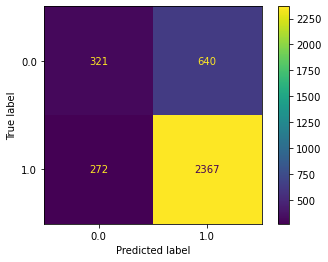

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

model_cm = confusion_matrix(y_true=y_pred, y_pred=y_pred)

plt.figure()
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

In [41]:
# Check accuracy
(2367+321)/(2367+272+321+640)

0.7466666666666667

In [43]:
# Naive bayes for test set
(2367+272)/(2367+272+321+640)

0.7330555555555556

Check naive bayes accuracy on whole dataset.

In [34]:
total_adopted = len(df[df['adopted_user']==1])

In [35]:
total_users = len(df)

In [36]:
total_adopted/total_users

0.7351666666666666

In [37]:
# Investigate result; are any variables correlated with the outcome?
X.corrwith(y)

creation_time                 0.015899
opted_in_to_mailing_list      0.010436
enabled_for_marketing_drip    0.012495
org_id                        0.009436
invited_by_user_id            0.020571
GUEST_INVITE                 -0.001555
ORG_INVITE                    0.023926
PERSONAL_PROJECTS            -0.390834
SIGNUP                        0.181221
SIGNUP_GOOGLE_AUTH            0.216800
dtype: float64

In [45]:
# The strongestest predictor was creation_source; 
# if they joined through an invitation to a personal project, they were slightly less likely to become an adopted user.

# Only 18% of users have this attribute
sum(X.PERSONAL_PROJECTS)/len(X)

0.17591666666666667